<a href="https://colab.research.google.com/github/AlvinScrp/d2l-zh-pytorch-colab/blob/main/chapter_attention-mechanisms/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install numpy d2l --no-deps # installing d2l # installing d2l

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.9 MB/s eta 0:00:00


# Transformer
:label:`sec_transformer`

 :numref:`subsec_cnn-rnn-self-attention`中比较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。值得注意的是，自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，使用自注意力来设计深度架构是很有吸引力的。对比之前仍然依赖循环神经网络实现输入表示的自注意力模型 :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017`，Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。尽管Transformer最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 模型

Transformer作为编码器－解码器架构的一个实例，其整体架构图在 :numref:`fig_transformer`中展示。正如所见到的，Transformer是由编码器和解码器组成的。与 :numref:`fig_s2s_attention_details`中基于Bahdanau注意力实现的序列到序列的学习相比，Transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的*嵌入*（embedding）表示将加上*位置编码*（positional encoding），再分别输入到编码器和解码器中。

![transformer架构](http://d2l.ai/_images/transformer.svg)
:width:`500px`
:label:`fig_transformer`

图 :numref:`fig_transformer`中概述了Transformer的架构。从宏观角度来看，Transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。第一个子层是*多头自注意力*（multi-head self-attention）汇聚；第二个子层是*基于位置的前馈网络*（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受 :numref:`sec_resnet`中残差网络的启发，每个子层都采用了*残差连接*（residual connection）。在Transformer中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。在残差连接的加法计算之后，紧接着应用*层规范化*（layer normalization） :cite:`Ba.Kiros.Hinton.2016`。因此，输入序列对应的每个位置，Transformer编码器都将输出一个$d$维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为*编码器－解码器注意力*（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种*掩蔽*（masked）注意力保留了*自回归*（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

在此之前已经描述并实现了基于缩放点积多头注意力 :numref:`sec_multihead-attention`和位置编码 :numref:`subsec_positional-encoding`。接下来将实现Transformer模型的剩余部分。


In [ ]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 注意力分数(多头、缩放点积、掩码)

In [ ]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        dk = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(dk)
        # print("scores",scores)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # print("attention_weights",self.attention_weights)
        return torch.bmm(self.dropout(self.attention_weights), values)

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X



In [ ]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4130, 0.2687, 0.3183, 0.0000]],

        [[0.5184, 0.4816, 0.0000, 0.0000],
         [0.2716, 0.3056, 0.2823, 0.1405]]])

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5279, 0.4721, 0.0000, 0.0000],
         [0.5938, 0.4062, 0.0000, 0.0000]],

        [[0.3600, 0.3803, 0.2597, 0.0000],
         [0.3725, 0.2162, 0.4113, 0.0000]]])

In [ ]:
keys = torch.arange(40, dtype=torch.float32).reshape(2, 10, 2)
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])
queries = torch.normal(0, 1, (2, 1, 2))
print("queries",queries)
# print("keys",keys)
print("values",values)
attention = DotProductAttention(dropout=0.5)
attention.eval() #评估模式dropout无效
attention(queries, keys, values, valid_lens)

queries tensor([[[0.2513, 1.2275]],

        [[0.7612, 0.6926]]])
values tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.],
         [24., 25., 26., 27.],
         [28., 29., 30., 31.],
         [32., 33., 34., 35.],
         [36., 37., 38., 39.]],

        [[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.],
         [24., 25., 26., 27.],
         [28., 29., 30., 31.],
         [32., 33., 34., 35.],
         [36., 37., 38., 39.]]])


tensor([[[ 3.5602,  4.5602,  5.5602,  6.5602]],

        [[19.4131, 20.4131, 21.4131, 22.4131]]])

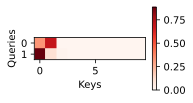

In [ ]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


In [ ]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queriesX, keysY, valuesZ, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queriesX), self.num_heads)
        keys = transpose_qkv(self.W_k(keysY), self.num_heads)
        values = transpose_qkv(self.W_v(valuesZ), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)



def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

## 位置编码 PositionalEncoding

In [ ]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        # seq (max_len,1), twoK (d/2)
        seq = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)
        twoK = torch.arange(0, num_hiddens, 2, dtype=torch.float32)
        X = seq / torch.pow(10000, twoK / num_hiddens)

        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

        print(self.P[0][0][:8])
        print(self.P[0][1][:8])
        print(self.P[0][2][:8])
        print(self.P[0][3][:8])
        print(math.sin(0),math.cos(0))
        print(math.sin(1),math.cos(1))
        print(math.sin(2),math.cos(2))
        print(math.sin(3),math.cos(3))

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

tensor([0., 1., 0., 1., 0., 1., 0., 1.])
tensor([0.8415, 0.5403, 0.5332, 0.8460, 0.3110, 0.9504, 0.1769, 0.9842])
tensor([ 0.9093, -0.4161,  0.9021,  0.4315,  0.5911,  0.8066,  0.3482,  0.9374])
tensor([ 0.1411, -0.9900,  0.9933, -0.1160,  0.8126,  0.5828,  0.5085,  0.8610])
0.0 1.0
0.8414709848078965 0.5403023058681398
0.9092974268256817 -0.4161468365471424
0.1411200080598672 -0.9899924966004454


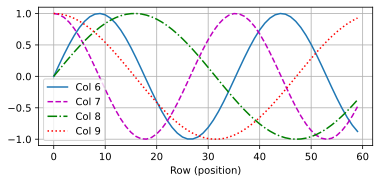

In [ ]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0,60)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

## [**基于位置的前馈网络**]

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是*基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。


In [ ]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

下面的例子显示，[**改变张量的最里层维度的尺寸**]，会改变成基于位置的前馈网络的输出尺寸。因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。


In [ ]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()

ffn(torch.ones((2, 3, 4))).shape,ffn(torch.ones((2, 3, 4)))[0]

(torch.Size([2, 3, 8]),
 tensor([[ 0.1046,  0.2348,  0.1530,  0.0491, -0.2924,  0.0922,  0.2950, -0.4224],
         [ 0.1046,  0.2348,  0.1530,  0.0491, -0.2924,  0.0922,  0.2950, -0.4224],
         [ 0.1046,  0.2348,  0.1530,  0.0491, -0.2924,  0.0922,  0.2950, -0.4224]],
        grad_fn=<SelectBackward0>))

## 残差连接和层规范化

现在让我们关注 :numref:`fig_transformer`中的*加法和规范化*（add&norm）组件。正如在本节开头所述，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

 :numref:`sec_batch_norm`中解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

以下代码[**对比不同维度的层规范化和批量规范化的效果**]。


In [ ]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以[**使用残差连接和层规范化**]来实现`AddNorm`类。暂退法也被作为正则化方法使用。


In [ ]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

残差连接要求两个输入的形状相同，以便[**加法操作后输出张量的形状相同**]。


In [ ]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## EncoderDecoder

In [ ]:
from torch import nn


class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class AttentionDecoder(Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)



## 编码器

有了组成Transformer编码器的基础组件，现在可以先[**实现编码器中的一个层**]。下面的`EncoderBlock`类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。


In [ ]:
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

正如从代码中所看到的，[**Transformer编码器中的任何层都不会改变其输入的形状**]。


In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

下面实现的[**Transformer编码器**]的代码中，堆叠了`num_layers`个`EncoderBlock`类的实例。由于这里使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。


In [ ]:
class TransformerEncoder(Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

下面我们指定了超参数来[**创建一个两层的Transformer编码器**]。
Transformer编码器输出的形状是（批量大小，时间步数目，`num_hiddens`）。


In [ ]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

tensor([0., 1., 0., 1., 0., 1., 0., 1.])
tensor([0.8415, 0.5403, 0.4477, 0.8942, 0.2138, 0.9769, 0.0998, 0.9950])
tensor([ 0.9093, -0.4161,  0.8006,  0.5992,  0.4177,  0.9086,  0.1987,  0.9801])
tensor([ 0.1411, -0.9900,  0.9841,  0.1774,  0.6023,  0.7983,  0.2955,  0.9553])
0.0 1.0
0.8414709848078965 0.5403023058681398
0.9092974268256817 -0.4161468365471424
0.1411200080598672 -0.9899924966004454


torch.Size([2, 100, 24])

## 解码器

如 :numref:`fig_transformer`所示，[**Transformer解码器也是由多个相同的层组成**]。在`DecoderBlock`类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。


In [ ]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，[**编码器和解码器的特征维度都是`num_hiddens`。**]


In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的[**Transformer解码器**]。最后，通过一个全连接层计算所有`vocab_size`个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。


In [ ]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## [**训练**]

依照Transformer架构来实例化编码器－解码器模型。在这里，指定Transformer的编码器和解码器都是2层，都使用4头注意力。与 :numref:`sec_seq2seq_training`类似，为了进行序列到序列的学习，下面在“英语－法语”机器翻译数据集上训练Transformer模型。


### function：train_seq2seq

In [ ]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

### 机器翻译和数据集
d2l.load_data_nmt

https://github.com/AlvinScrp/d2l-zh-pytorch-colab/blob/main/chapter_recurrent-modern/machine-translation-and-dataset.ipynb

### 执行训练

loss 0.031, 4424.2 tokens/sec on cpu


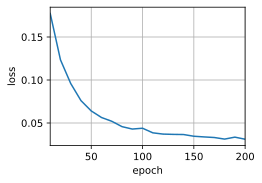

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测

### 预测方法

In [3]:
import collections
import math
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

### 执行预测

训练结束后，使用Transformer模型[**将一些英语句子翻译成法语**]，并且计算它们的BLEU分数。


In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

当进行最后一个英语到法语的句子翻译工作时，让我们[**可视化Transformer的注意力权重**]。编码器自注意力权重的形状为（编码器层数，注意力头数，`num_steps`或查询的数目，`num_steps`或“键－值”对的数目）。


In [ ]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。


In [ ]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

[**为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。**]例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以*序列开始词元*（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。


In [ ]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。


In [ ]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器的自注意力的情况类似，通过指定输入序列的有效长度，[**输出序列的查询不会与输入序列中填充位置的词元进行注意力计算**]。


In [ ]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

尽管Transformer架构是为了*序列到序列*的学习而提出的，但正如本书后面将提及的那样，Transformer编码器或Transformer解码器通常被单独用于不同的深度学习任务中。

## 小结

* Transformer是编码器－解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用。
* 在Transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
* Transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
* Transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。

## 练习

1. 在实验中训练更深的Transformer将如何影响训练速度和翻译效果？
1. 在Transformer中使用加性注意力取代缩放点积注意力是不是个好办法？为什么？
1. 对于语言模型，应该使用Transformer的编码器还是解码器，或者两者都用？如何设计？
1. 如果输入序列很长，Transformer会面临什么挑战？为什么？
1. 如何提高Transformer的计算速度和内存使用效率？提示：可以参考论文 :cite:`Tay.Dehghani.Bahri.ea.2020`。
1. 如果不使用卷积神经网络，如何设计基于Transformer模型的图像分类任务？提示：可以参考Vision Transformer :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。


[Discussions](https://discuss.d2l.ai/t/5756)
